# Using Cosine Similarity to Determine Recommendations

## Cosine Similartiy Overview

Cosine Similarity is the normalized dot product of two vectors, A & B, and can be written as such:

$$cos(\theta) = \frac{AB^T}{\|A\|\|B\|}$$

In the instance of this recommender the two vectors are the same, the overall song matrix derived in the Preprocessing notebook.

## Why Cosine Similarity?

The short of this is: Because it provided results that sounded the most similar to songs provided in testing.

### Analysis

I think intuitively, that a measurement like Euclidean distance makes more sense when trying to measure the similarity of songs using the feature sets that are incorporated here, wherein the most of the features are measurements centered around zero. However, in aggregate, the test results using Cosine similarity sounded closer to the original titles provided than the results utilizing euclidean distance. The songs recommended through cosine similarity were also more diverse, in terms of the performing artist. Wherein, usine euclidean distance, there was a higher frequency of the same artist who

Cosine similarity also works well for dense data sets, which is exactly what we have for the genre based features passed through SVD. It's built to better incorporate the directionality of those genre components regardless of their magnitude.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

##### Loading in matricies and df's from preprocessing

In [2]:
with open('../pickle/svd_matrix.pkl', 'rb') as f:
    svd_matrix = pickle.load(f)
svd_df = pd.read_csv('../data/svd_df.csv', index_col='song_id')

In [30]:
with open('../pickle/main_songs_scaled_svd.pkl', 'rb') as f:
    main_songs_scaled_svd = pickle.load(f)
main_songs_svdg = pd.read_csv('../data/main_songs_svdg.csv', index_col='song_id')

In [4]:
with open('../pickle/main_songs_scaled_nmfg.pkl', 'rb') as f:
    main_songs_scaled_nmfg = pickle.load(f)

In [121]:
with open('../pickle/main_songs_scaled_af.pkl', 'rb') as f:
    main_songs_scaled_af = pickle.load(f)

##### Retrieving the Primary Song Listing to help Lookup Song Titles

In [5]:
main_song_list = pd.read_csv('../data/main_wfeats.csv', index_col='song_id')

## Precomputing Cosine Similarity Matrix

##### SVD on All Features

In [6]:
cos_sim_mat = cosine_similarity(svd_matrix, svd_matrix)
cos_sim_mat.shape

(22891, 22891)

##### SVD on Genres Only (50 total) + All Other Song Features

In [31]:
cos_sim_mat_g = cosine_similarity(main_songs_scaled_svd, main_songs_scaled_svd)
cos_sim_mat_g.shape

(22891, 22891)

##### NMF on Genres Only (50 total) + All Other Song Features

In [114]:
cos_sim_mat_nmfg = cosine_similarity(main_songs_scaled_nmfg, main_songs_scaled_nmfg)
cos_sim_mat_nmfg.shape

(22891, 22891)

In [122]:
cos_sim_mat_af = cosine_similarity(main_songs_scaled_af, main_songs_scaled_af)
cos_sim_mat_af.shape

(22891, 22891)

### Creating a Series of `dicts` for Lookup

In [7]:
song_id_name = dict(zip(main_song_list.index, main_song_list['song_title']))

In [8]:
song_id_artist = dict(zip(main_song_list.index, main_song_list['artist_name']))

In [9]:
song_id_name['6SluaPiV04KOaRTOIScoff']

'Show Me Love - Radio Version'

In [34]:
song_cosine_id = dict(zip(main_songs_svdg.index, range(main_songs_svdg.shape[0])))

In [35]:
song_cosine_idr = dict(zip(range(main_songs_svdg.shape[0]), main_songs_svdg.index))

## Searching for Most Similar Songs (Regardless of Artist)

In [38]:
def feat_sim(song_id, k=10, cos_sim_mat=cos_sim_mat_g):
    '''
    Returns array of indices for top k songs with greatest similarity to given song, along with 
    their similarity rating, based on precomputed cosine similarity of feature vectors.

    top_songs_feat, top_songs_feat_sim = get_sim.by_feats(ind_song_id, k, cos_sim_mat)

    '''
    top_songs_feat = np.argsort(cos_sim_mat[song_cosine_id[song_id]])[-2:-(k+2):-1]
    top_songs_feat_sim = np.sort(cos_sim_mat[song_cosine_id[song_id]])[-2:-(k+2):-1]

    return top_songs_feat, top_songs_feat_sim

## Searching for Most Similar Songs (Must be Different Artist)

In [79]:
def feat_sim_da(song_id, k=10, song_db=main_song_list, cos_sim_mat=cos_sim_mat_g):
    '''
    Returns array of indices for top k songs with greatest similarity to a given song, but only
    from artists who didn't perform the given song, along with their similarity rating, 
    based on precomputed cosine similarity of feature vectors.

    top_songs_feat, top_songs_feat_sim = get_sim.by_feats(ind_song_id, k, cos_sim_mat)
    '''
    artist_id = song_db.loc[song_id, 'artist_id']
    artist_songs = song_db.index[song_db['artist_id'] == artist_id].drop(song_id)
    top_songs_feat = np.argsort(cos_sim_mat[song_cosine_id[song_id]])[-2:-(k+12):-1]
    top_songs_feat_sim = np.sort(cos_sim_mat[song_cosine_id[song_id]])[-2:-(k+12):-1]
    
    return top_songs_feat, top_songs_feat_sim, artist_songs

## Function to Derive Most Similar Titles Using Cosine Similarity Matrix

### For Recs Regardless of Artist

In [82]:
def get_recs(song_id, k=10, cos_sim_mat=cos_sim_mat_g):
    try:
        top_songs_feat, top_songs_feat_sim = feat_sim(song_id, k, cos_sim_mat)
        return pd.DataFrame([[song_id_name[song_cosine_idr[x]] for x in top_songs_feat],
                         [song_id_artist[song_cosine_idr[x]] for x in top_songs_feat],
                         [song_cosine_idr[x] for x in top_songs_feat],
                         list(top_songs_feat_sim)], 
                        index=['Song Name', 'Artist', 'Song ID', 'Similarity']).T
    except:
        print('No results available for that id. Please refer to the Song Finder for a list of valid ids.')

#### SVD Genres Only

In [83]:
#Show Me Love (Radio Version) - Robyn
get_recs('6sbXGUn9V9ZaLwLdOfpKRE', k=10)

,Song Name,Artist,Song ID,Similarity
0,Roses Are Red - Original Version,Aqua,4qZwVr553XcQNdeqjueeE3,0.760277
1,Mi chico latino,Geri Halliwell,3Qu88IYwuDpUQNi6UwJsDz,0.730139
2,It's Raining Men,Geri Halliwell,7q3qX7Ees3FZtRFJXWgPZs,0.725041
3,It's Gonna Be Me,*NSYNC,2AW37v0bDyuOzGP3XnmFuA,0.707045
4,Rock DJ,Robbie Williams,7oQSevUCbYs4QawXTHQVV1,0.692226
5,Spice Up Your Life,Spice Girls,5qGwqO0lkbBXw4xNfzT7SF,0.686553
6,Lollipop (Candyman),Aqua,5tnqSEWM3EKoEtjSZpmHcH,0.672954
7,Who Do You Think You Are,Spice Girls,1jI1aLmm5HTwiMtvsbwDJw,0.655367
8,Candy,Robbie Williams,0HM2ROsAWTmvHaYA2XHlBh,0.651963
9,Bag It Up,Geri Halliwell,6tciQYmD0nQCdDE4IQCrdy,0.650331


In [84]:
#Finesse (Remix) - Bruno Mars (feat. Cardi B)
get_recs('3Vo4wInECJQuz9BIBMOu8i', k=10)

,Song Name,Artist,Song ID,Similarity
0,That's What I Like - PARTYNEXTDOOR Remix,Bruno Mars,64TkpV7m7f09JY7K436pju,0.803541
1,The Party's Just Begun,The Cheetah Girls,5Au8ObNQvrwFVEgGqQQL6D,0.710488
2,24K Magic,Bruno Mars,6b8Be6ljOzmkOmFslEb23P,0.674512
3,One World - Soundtrack,The Cheetah Girls,7luYEwE4Y9Of5AKbrt0pJ4,0.674079
4,Good Day,DNCE,49X8pWDpmFpAITVUaudkcN,0.662769
5,Valerie - Glee Cast Version,Glee Cast,4hBW3h6FnQNh7NRmyxLLG7,0.654222
6,Malibu - Tiësto Remix,Miley Cyrus,7FKcbKrAi4uiXosKMNTjQI,0.645558
7,Lone Ranger,Rachel Platten,3eoyz3jZOHhko7hEwtEdnf,0.642873
8,24/Seven,Big Time Rush,6FkX1akf4mwRZSznL73kDR,0.642443
9,All In My Head (Flex),Fifth Harmony,7nD9nN3jord9wWcfW3Gkcm,0.639749


In [126]:
#Clique - Kanye West
get_recs('3rbNV2GI8Vtd8byhUtXZID', k=10)

,Song Name,Artist,Song ID,Similarity
0,Willy Wonka (feat. Offset),Macklemore,7uKSil5r7uHexnM9lukPTc,0.765891
1,3005,Childish Gambino,3Z2sglqDj1rDRMF5x0Sz2R,0.68663
2,Ladders,Mac Miller,39NDBdU5Xkm5pCFGa5kZtI,0.643684
3,No Role Modelz,J. Cole,62vpWI1CHwFy7tMIcSStl8,0.640834
4,Thrift Shop (feat. Wanz),Macklemore & Ryan Lewis,3AYcyxEACnmE6d96RPubID,0.634141
5,Freaks And Geeks,Childish Gambino,7xTY3rJMgj0nh6OOPHgsLw,0.623547
6,Ghost Town,Kanye West,6Bg7MznA9X0dIhlAsLyBYj,0.622416
7,By Design,Kid Cudi,5FxVTEpoBress37MmlMhbZ,0.618671
8,Don't Like.1,Kanye West,12D0n7hKpPcjuUpcbAKjjr,0.613521
9,God's Plan,Drake,6DCZcSspjsKoFjzjrWoCdn,0.607984


In [127]:
# Guess Who's Back - Scarface
get_recs('27dUo79lgLEy4Rk5w3UvSL', k=10, cos_sim_mat=cos_sim_mat_g)

,Song Name,Artist,Song ID,Similarity
0,Young Boy,Clipse,5fuckUyGUsTPJEugfXNsjw,0.734308
1,No Tears,Scarface,6kYTywTCfycHZcH0WdLyRy,0.731792
2,Mr. Me Too,Clipse,6cAldqwmbUwpM8D17FWtPL,0.73072
3,Mary Jane,Scarface,52VpJGxfpghObsAtML7kaN,0.704785
4,I'm Throwed (feat. Jermaine Dupri),Paul Wall,3n5rIcC04MiNx4T2GOS06g,0.697113
5,My Buddy,G-Unit,3iyZRwIGmyXvdZMoxOlur7,0.690831
6,"Akickdoe! - feat. Pimp, Bun B, and Master P",C-Murder,6MGZkm9RcfxTONlFow4Lb6,0.68075
7,Smile,Scarface,2wxO3ZydJTZRi4Bbc02q7i,0.680188
8,On My Block,Scarface,3XcsaghGUCL9WzJz3TlLKo,0.672679
9,Smoke Buddah,Redman,3eY9pixHny3kVRLeqNezQx,0.671776


Recs here aren't great. I'm assuming now that performing SVD on just genres, giving more weight to the actual tonal qualities of the music, adversely affected Hip Hop recommendations. This could be because either none of the aforementioned qualities capture the diversity in themes or aggression that rap songs can have, depending upon the subject matter and rapper themselves. In short, while they're both great songs, I would not recommend *Mr. Me Too* based off of someone enjoying *Guess Who's Back*.

In [86]:
get_recs('69ku805AjIcFQh0IfkGohf', k=10, cos_sim_mat=cos_sim_mat_g)

,Song Name,Artist,Song ID,Similarity
0,Gone Country,Alan Jackson,6IEIPevuDocD80PovsX6kN,0.777332
1,My Kind Of Beautiful,Andy Griggs,6nERPmnWR6gE9Lys5AMPqi,0.761895
2,Unsung Heroes,Darryl Worley,2NBGNKapS05nmPalkrL2Df,0.721247
3,Good Morning Beautiful - Acoustic Version,Steve Holy,6cYgHLp1daka1Frs8s2YtV,0.711288
4,Living In A Moment,Ty Herndon,1cbgg9MvWjM9LWk2mUQ3zS,0.701714
5,Busy Man,Billy Ray Cyrus,55bwRyNowFFB5Kp0Ojkvhx,0.695803
6,Bye Bye,Phil Vassar,6CebGuHR99xrFitTnOgeu2,0.689937
7,Steady as She Goes,Wade Hayes,5g3BiTBZqPRc6fx2m7Hq3L,0.683843
8,Boys from the South,Pistol Annies,57DLMHlHkUdWIecKgpTx8v,0.683179
9,Bigger Than the Beatles,Joe Diffie,0JqSbF5Z7rFQSflSksEI8E,0.680488


In [87]:
get_recs('6SluaPiV04KOaRTOIScoff', k=10, cos_sim_mat=cos_sim_mat_g)

,Song Name,Artist,Song ID,Similarity
0,Be Mine!,Robyn,3FtkFLmplS7GGPFMIQ0dSR,0.807176
1,Do You Know (What It Takes),Robyn,0idCpkJ2pspfAILbanmERu,0.73661
2,Fuck You,Lily Allen,1GCbc1vpkZA2zhjsSFhmHT,0.69611
3,Wannabe,Spice Girls,1Je1IMUlBXcx1Fz0WE7oPT,0.686487
4,2 Become 1,Spice Girls,36AWdhZIGLUTkWpJDhe7va,0.672988
5,Hang With Me,Robyn,6rW8q1p2GCjGMRAlnxBeo7,0.665758
6,Viva Forever,Spice Girls,6BPDPcnbDMDf58srVzbfX9,0.663578
7,Who Do You Think You Are,Spice Girls,1jI1aLmm5HTwiMtvsbwDJw,0.658066
8,Cruel Summer,Ace of Base,4AxVXHgv0clBuS4dl4S7Gw,0.636947
9,Barbie Girl,Aqua,2RSOzvKUnfDDrb2nQPfpQU,0.629162


#### NMF Genres Only

In [115]:
# 
get_recs('6SluaPiV04KOaRTOIScoff', k=10, cos_sim_mat=cos_sim_mat_nmfg)

,Song Name,Artist,Song ID,Similarity
0,Be Mine!,Robyn,3FtkFLmplS7GGPFMIQ0dSR,0.807298
1,Do You Know (What It Takes),Robyn,0idCpkJ2pspfAILbanmERu,0.736749
2,Fuck You,Lily Allen,1GCbc1vpkZA2zhjsSFhmHT,0.694513
3,Wannabe,Spice Girls,1Je1IMUlBXcx1Fz0WE7oPT,0.684678
4,2 Become 1,Spice Girls,36AWdhZIGLUTkWpJDhe7va,0.671122
5,Hang With Me,Robyn,6rW8q1p2GCjGMRAlnxBeo7,0.665977
6,Viva Forever,Spice Girls,6BPDPcnbDMDf58srVzbfX9,0.661496
7,Who Do You Think You Are,Spice Girls,1jI1aLmm5HTwiMtvsbwDJw,0.655971
8,Say You'll Be There - シングル・ミックス,Spice Girls,1yTQ39my3MoNROlFw3RDNy,0.621182
9,Dancing On My Own - Radio Edit,Robyn,7g13jf3zqlP5S68Voo5v9m,0.620747


In [116]:
# Guess Who's Back - Scarface
get_recs('27dUo79lgLEy4Rk5w3UvSL', k=10, cos_sim_mat=cos_sim_mat_nmfg)

,Song Name,Artist,Song ID,Similarity
0,Young Boy,Clipse,5fuckUyGUsTPJEugfXNsjw,0.733536
1,No Tears,Scarface,6kYTywTCfycHZcH0WdLyRy,0.730979
2,Mr. Me Too,Clipse,6cAldqwmbUwpM8D17FWtPL,0.729955
3,Mary Jane,Scarface,52VpJGxfpghObsAtML7kaN,0.70373
4,I'm Throwed (feat. Jermaine Dupri),Paul Wall,3n5rIcC04MiNx4T2GOS06g,0.696336
5,My Buddy,G-Unit,3iyZRwIGmyXvdZMoxOlur7,0.689718
6,"Akickdoe! - feat. Pimp, Bun B, and Master P",C-Murder,6MGZkm9RcfxTONlFow4Lb6,0.681252
7,Smile,Scarface,2wxO3ZydJTZRi4Bbc02q7i,0.678955
8,On My Block,Scarface,3XcsaghGUCL9WzJz3TlLKo,0.671551
9,Smoke Buddah,Redman,3eY9pixHny3kVRLeqNezQx,0.67098


In [117]:
# Clique - Kanye West
get_recs('3rbNV2GI8Vtd8byhUtXZID', k=10, cos_sim_mat=cos_sim_mat_nmfg)

,Song Name,Artist,Song ID,Similarity
0,Willy Wonka (feat. Offset),Macklemore,7uKSil5r7uHexnM9lukPTc,0.766099
1,3005,Childish Gambino,3Z2sglqDj1rDRMF5x0Sz2R,0.692085
2,Ladders,Mac Miller,39NDBdU5Xkm5pCFGa5kZtI,0.652304
3,No Role Modelz,J. Cole,62vpWI1CHwFy7tMIcSStl8,0.635105
4,Ghost Town,Kanye West,6Bg7MznA9X0dIhlAsLyBYj,0.632292
5,Freaks And Geeks,Childish Gambino,7xTY3rJMgj0nh6OOPHgsLw,0.630839
6,By Design,Kid Cudi,5FxVTEpoBress37MmlMhbZ,0.628362
7,Don't Like.1,Kanye West,12D0n7hKpPcjuUpcbAKjjr,0.624216
8,Thrift Shop (feat. Wanz),Macklemore & Ryan Lewis,3AYcyxEACnmE6d96RPubID,0.618682
9,God's Plan,Drake,6DCZcSspjsKoFjzjrWoCdn,0.615009


In [118]:
#Finesse (Remix) - Bruno Mars (feat. Cardi B)
get_recs('3Vo4wInECJQuz9BIBMOu8i', k=10, cos_sim_mat=cos_sim_mat_nmfg)

,Song Name,Artist,Song ID,Similarity
0,That's What I Like - PARTYNEXTDOOR Remix,Bruno Mars,64TkpV7m7f09JY7K436pju,0.806191
1,The Party's Just Begun,The Cheetah Girls,5Au8ObNQvrwFVEgGqQQL6D,0.703548
2,24K Magic,Bruno Mars,6b8Be6ljOzmkOmFslEb23P,0.678122
3,One World - Soundtrack,The Cheetah Girls,7luYEwE4Y9Of5AKbrt0pJ4,0.66753
4,Valerie - Glee Cast Version,Glee Cast,4hBW3h6FnQNh7NRmyxLLG7,0.659563
5,Good Day,DNCE,49X8pWDpmFpAITVUaudkcN,0.651185
6,24/Seven,Big Time Rush,6FkX1akf4mwRZSznL73kDR,0.635122
7,Malibu - Tiësto Remix,Miley Cyrus,7FKcbKrAi4uiXosKMNTjQI,0.634783
8,Run the World (Girls),Beyoncé,1uXbwHHfgsXcUKfSZw5ZJ0,0.634183
9,All In My Head (Flex),Fifth Harmony,7nD9nN3jord9wWcfW3Gkcm,0.633767


#### No Genres

In [123]:
#Show Me Love (Radio Version) - Robyn
get_recs('6SluaPiV04KOaRTOIScoff', k=10, cos_sim_mat=cos_sim_mat_af)

,Song Name,Artist,Song ID,Similarity
0,Mrs. Potato Head,Melanie Martinez,3K1tdhoeE6koNnWgAxEK9Y,0.680341
1,You Better Listen,Sublime With Rome,0UjhtgLGvbS8pBgQ4RIihW,0.661197
2,I'm Down,Aaliyah,444Rzzl3T2YOoAN4nQNoMI,0.647382
3,Ain't My Fault,Zara Larsson,0ADG9OgdVTL7fgREP75BrZ,0.641046
4,"Genius - with Sia, Diplo & Labrinth",Sia,73F87Sqh6jQWucOOvz1WFx,0.631186
5,Stripsearch - 2016 Remastered Version,Faith No More,0LErw54mr0L2fQDR8DMLh2,0.627506
6,Centuries,Fall Out Boy,04aAxqtGp5pv12UXAg4pkq,0.622403
7,Ain't My Fault - R3hab Remix,Zara Larsson,3YPlsrk0Voe8AOa1jyN891,0.620697
8,Roar,Katy Perry,6F5c58TMEs1byxUstkzVeM,0.619416
9,The Holy Grail,John Fogerty,6dh3RjahKiBrygKA8we05z,0.611681


In [124]:
#Finesse (Remix) (feat. Cardi B) - Bruno Mars
get_recs('3Vo4wInECJQuz9BIBMOu8i', k=10, cos_sim_mat=cos_sim_mat_af)

,Song Name,Artist,Song ID,Similarity
0,Take You There,Sean Kingston,6AdLyvisRKHLAwARaZMGr6,0.838186
1,I Could Be The One,Stacie Orrico,0cBHjx5NwJFAFMSYO7Uak9,0.734053
2,The Party's Just Begun,The Cheetah Girls,5Au8ObNQvrwFVEgGqQQL6D,0.730922
3,Object Of My Desire,Starpoint,63Ql2zSLiBryLRPihaUToK,0.72717
4,Who's In The House,Carman,602otoaP8ITTHNlpAbe1WT,0.726203
5,Todo Lo Que Sube Baja,Olga Tanon,4U0wBFXkq5pnMVAZdNKpRf,0.722698
6,Disco Nights (Rock Freak) (Edit),G.Q.,5Ftiez8SeofWdg8cqqiEmm,0.715116
7,Everybody Everybody - Lelewel Re-Freak Mix,Black Box,4vG2cYhMz6Oq4aEKo3GwV1,0.705337
8,True Fuschnick,FU-Schnickens,3oaWYEUBZ4QXrx4qgGIRwF,0.700244
9,Last Night,Keyshia Cole,3Cn1FSSTXeQ7hCfrbizrD0,0.697212


In [125]:
# Clique - Kanye West
get_recs('3rbNV2GI8Vtd8byhUtXZID', k=10, cos_sim_mat=cos_sim_mat_af)

,Song Name,Artist,Song ID,Similarity
0,Master Thesis,Canibus,1xDJGJLS3DwcxRyacQXNbd,0.752429
1,Willy Wonka (feat. Offset),Macklemore,7uKSil5r7uHexnM9lukPTc,0.749893
2,Get Me Home,Foxy Brown,6Xo9osN1HErsEJoqwj4eDg,0.748324
3,Ali Bomaye,The Game,0LFcFGLYTX6UmeIdO7NVd7,0.746301
4,100 Bars,Canibus,4FBzlDdNlnQH03zCwNv3GZ,0.740567
5,Hate Me Now,Nas,158DIbrVt4YbqNnWyRCS3P,0.710441
6,8 Iz Enuff,Big L,5LZ4d69L4TK8hVyh2q7YEJ,0.702978
7,Radio,Keith Murray,7sq0xuxswwUuHgRFEe3vjB,0.665399
8,My Shit Bang,E-40,7eaEXFYxeRs0TMXFyayhdo,0.663826
9,Desperados,Canibus,7xkSrWq4k87x1tYkaTkqMS,0.66093


### Must be Different Artist

In [96]:
def get_recs_da(song_id, k=10, song_db=main_song_list, cos_sim_mat=cos_sim_mat_g):
    top_songs_feat, top_songs_feat_sim, artist_songs = feat_sim_da(song_id, k, main_song_list, cos_sim_mat)
    recs = [
        [song_id_name[song_cosine_idr[x]] for x in top_songs_feat],
        [song_id_artist[song_cosine_idr[x]] for x in top_songs_feat],
        [song_cosine_idr[x] for x in top_songs_feat],
        list(top_songs_feat_sim)
    ]
    
    recs = pd.DataFrame(recs, index=['Song Name', 'Artist', 'Song ID', 'Similarity']).T
    recs.set_index('Song ID', inplace=True)
    
    for song in artist_songs:
        if song in recs.index:
            recs.drop(song, inplace=True)
            
    recs.reset_index(inplace=True)
    return recs.head(k)
#     except:
#         print('No results available for that id. Please refer to the Song Finder for a list of valid ids.')

In [98]:
get_recs_da('6SluaPiV04KOaRTOIScoff')

,Song ID,Song Name,Artist,Similarity
0,1GCbc1vpkZA2zhjsSFhmHT,Fuck You,Lily Allen,0.69611
1,1Je1IMUlBXcx1Fz0WE7oPT,Wannabe,Spice Girls,0.686487
2,36AWdhZIGLUTkWpJDhe7va,2 Become 1,Spice Girls,0.672988
3,6BPDPcnbDMDf58srVzbfX9,Viva Forever,Spice Girls,0.663578
4,1jI1aLmm5HTwiMtvsbwDJw,Who Do You Think You Are,Spice Girls,0.658066
5,4AxVXHgv0clBuS4dl4S7Gw,Cruel Summer,Ace of Base,0.636947
6,2RSOzvKUnfDDrb2nQPfpQU,Barbie Girl,Aqua,0.629162
7,1yTQ39my3MoNROlFw3RDNy,Say You'll Be There - シングル・ミックス,Spice Girls,0.623271
8,1NwDWbpg9dPH12xBd2ibrv,Holler,Spice Girls,0.617183
9,3BsaRV5QIulYz2lV9WWa8T,Show Me the Meaning of Being Lonely,Backstreet Boys,0.61627


##### SVD Genres Only

In [112]:
get_recs_da('6SluaPiV04KOaRTOIScoff', song_db=main_song_list, k=10, cos_sim_mat=cos_sim_mat_g)

,Song ID,Song Name,Artist,Similarity
0,1GCbc1vpkZA2zhjsSFhmHT,Fuck You,Lily Allen,0.69611
1,1Je1IMUlBXcx1Fz0WE7oPT,Wannabe,Spice Girls,0.686487
2,36AWdhZIGLUTkWpJDhe7va,2 Become 1,Spice Girls,0.672988
3,6BPDPcnbDMDf58srVzbfX9,Viva Forever,Spice Girls,0.663578
4,1jI1aLmm5HTwiMtvsbwDJw,Who Do You Think You Are,Spice Girls,0.658066
5,4AxVXHgv0clBuS4dl4S7Gw,Cruel Summer,Ace of Base,0.636947
6,2RSOzvKUnfDDrb2nQPfpQU,Barbie Girl,Aqua,0.629162
7,1yTQ39my3MoNROlFw3RDNy,Say You'll Be There - シングル・ミックス,Spice Girls,0.623271
8,1NwDWbpg9dPH12xBd2ibrv,Holler,Spice Girls,0.617183
9,3BsaRV5QIulYz2lV9WWa8T,Show Me the Meaning of Being Lonely,Backstreet Boys,0.61627


In [69]:
main_song_list['artist_id'].loc['6SluaPiV04KOaRTOIScoff']

'6UE7nl9mha6s8z0wFQFIZ2'

In [60]:
main_song_list['artist_id'].loc['6SluaPiV04KOaRTOIScoff']

'6UE7nl9mha6s8z0wFQFIZ2'

## Looking at How Similarity Ranks Between Each Observation

##### Robyn - Show Me Love (Radio Version)

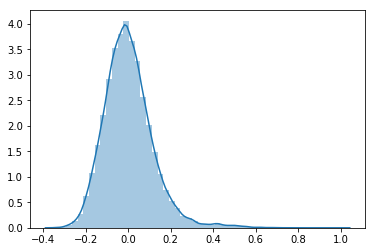

In [23]:
sns.distplot(cos_sim_mat_g[0]);

##### Bruno Mars - Finesse Remix (Feat. Cardi B)

In [21]:
svd_df.index.get_loc('3Vo4wInECJQuz9BIBMOu8i')

7949

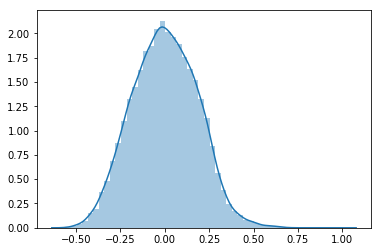

In [22]:
sns.distplot(cos_sim_mat_g[7949])

## Song Finder - An Easy Lookup Tool to Find Songs for Recommendations

In [ ]:
def song_finder(query, qtype='artist'):
    '''
    Retrieves song name and song id for a requested recording currently indexed
    '''
    